In [1]:
SEGMENTED_MODEL = False

In [2]:
def setup_file_system(in_colab):
    if in_colab:
        from google.colab import drive

        # Set the base and mount path
        MOUNT_PATH_DRIVE = '/content/drive'
        BASE_PATH = join(
            MOUNT_PATH_DRIVE, 
            "MyDrive/barco_skin_lesion_classification"
        )

        # Mount the google drive
        drive.mount(MOUNT_PATH_DRIVE)

        return BASE_PATH

    else:
        return "/workspaces/barco_skin_lesion_classification"

In [3]:
import sys
from os import chdir
from os.path import join

# Method to check if the notebook is running in colab or local
IN_COLAB = 'google.colab' in sys.modules

# Set the base path of the project
BASE_PATH = setup_file_system(IN_COLAB)

# Set the base path of the project
chdir(join(BASE_PATH, "src/"))

In [4]:
# Import libraries
from os.path import join
from tqdm import tqdm
import wandb
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# DL libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

# Metrics
from sklearn.metrics import f1_score, confusion_matrix

# User libraries
from util import config, model_management
from datasets.classificationdataset import ClassificationDataset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Get the data
dataset = ClassificationDataset(
    join(BASE_PATH, config.CLASSIFICATION_DATA_PATH_TEST_FEATURES),
    join(BASE_PATH, config.METADATA_TEST_PATH),
    config.CLASSIFICATION_TEST_TRANSFORMATIONS
  )

# Place the dataset in a dataloader
dataloader = DataLoader(dataset, batch_size=1)


In [6]:
# Start wandb
wandb.init(
    settings=wandb.Settings(start_method="fork"),
    project="classification_run", 
    config={
        "with_segmentation": SEGMENTED_MODEL,
        "model": config.SEGMENTED_CLASSIFICATION_ARTIFACT_CHECKPOINT if SEGMENTED_MODEL else config.UNSEGMENTED_CLASSIFICATION_ARTIFACT_CHECKPOINT,
        "image_dims": f'h: {config.CLASSIFICATION_IMAGE_HEIGHT}, w: {config.CLASSIFICATION_IMAGE_WIDTH}',
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: robberdg. Use `wandb login --relogin` to force relogin


In [7]:
torch.cuda.empty_cache()

# Get the model
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

# Replace the classifier
model.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1280 , 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(512 , 256),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(256 , 8),
            nn.Softmax(dim=1)
        )

# Send model to device
model.to(config.DEVICE)

# Get and set the saved model parameters
if SEGMENTED_MODEL:
    model_parameters = model_management.get_artifact_model_weights(config.SEGMENTED_CLASSIFICATION_ARTIFACT, config.SEGMENTED_CLASSIFICATION_ARTIFACT_CHECKPOINT)
else:
    model_parameters = model_management.get_artifact_model_weights(config.UNSEGMENTED_CLASSIFICATION_ARTIFACT, config.UNSEGMENTED_CLASSIFICATION_ARTIFACT_CHECKPOINT)
model.load_state_dict(torch.load(model_parameters))

# Place model in eval mode
model.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [8]:
# Set the evaluation data structures
pred_classes = []
true_classes = []

In [9]:
# run the model over the dataloader
loop = tqdm(dataloader, leave=True)
for idx, (input, label) in enumerate(loop):
    # Send the input and label to device
    input, label = input.to(config.DEVICE), label.to(config.DEVICE)

    # Send the input through the segmentation model
    output = model(input)[0]

    # Get the predicted class
    pred_class = torch.argmax(output)

    # update the evaluation data
    pred_classes.append(pred_class.item())
    true_classes.append(label.item())    

100%|██████████| 350/350 [00:12<00:00, 28.71it/s]


In [ ]:
# Per class f1 score
f1_score(true_classes, pred_classes, average=None)

In [10]:
# Average f1 score
f1_score(true_classes, pred_classes, average='macro')

0.06491880159912947

<AxesSubplot: >

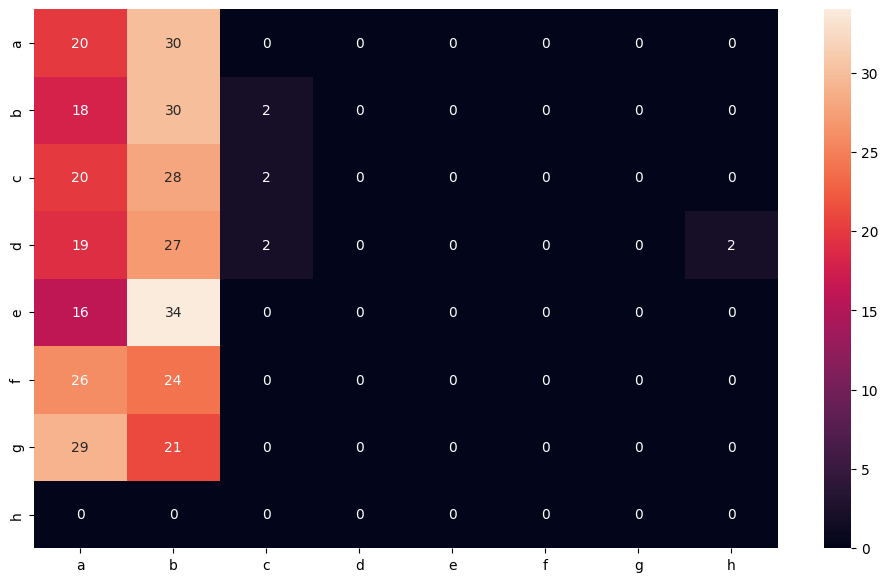

In [15]:
cf_matrix = confusion_matrix(true_classes, pred_classes)
cf_matrix_dataframe = pd.DataFrame(
    cf_matrix, 
    index = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec', 'other'], 
    columns = ['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec', 'other']
)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix_dataframe, annot=True, cbar=False)